# Learn some basic handling of geo-referenced data using gdal

This tutorial requires gdal and wget, though if you manually download the zip file you can dodge needing wget.

## First let's download some data

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import zipfile
import wget
import os
from osgeo import ogr, osr
import numpy as np

# now jump through a hupe to get our class definition
import sys
sys.path.append('../scripts')
from myclass import RasterDataset

In [2]:
z_fn = '../data/q1122.zip'
if not os.path.exists(z_fn):  # Otherwise these will stack up
    wget.download('http://gis.ess.washington.edu/data/raster/tenmeter/byquad/seattle/q1122.zip', out=z_fn) # download
    zip_ref = zipfile.ZipFile(z_fn, 'r')  # prepare for unzip
    zip_ref.extractall('../data/')
    zip_ref.close()

(<matplotlib.figure.Figure at 0x112179ba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112174710>)

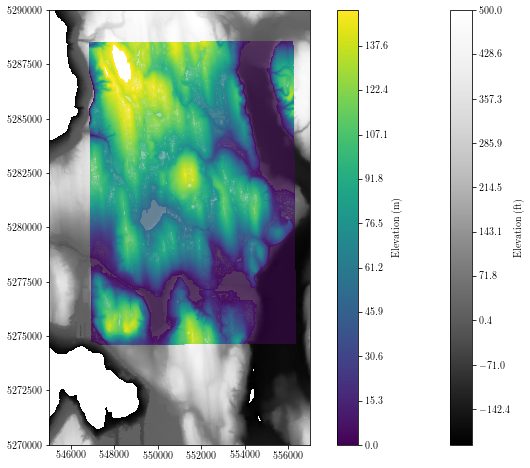

In [3]:
dem_fn = '../data/q1122.dem'
dem = RasterDataset(dem_fn)

# Bathymetry clipped from
# Finlayson D.P. (2005) Combined bathymetry and topography of the Puget Lowland, Washington State.
# University of Washington, (http://www.ocean.washington.edu/data/pugetsound/)
topo_dem_fn = '../data/psdem_2005.tif'
topo_dem = RasterDataset(topo_dem_fn)

def plot_dems():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_aspect('equal')
    cf = topo_dem.contourf(ax=ax, vmin=-200, vmax=500, cmap='Greys_r')
    cbr = plt.colorbar(cf)
    cbr.set_label('Elevation (ft)')  # Of course this is in feet... I've at least reprojected to meters though

    dcf = dem.contourf(ax=ax, vmin=0, vmax=150, alpha=0.5)
    cbr2 = plt.colorbar(dcf)
    cbr2.set_label('Elevation (m)')  # Some scientist must have made this one

    #I think this looks a lot nicer than having the transparent colorbar
    cbr2.set_alpha(1)
    cbr2.draw_all()
    return fig, ax

plot_dems()

## Now let's add a line shapefile

We can read it in with ogr as well

(5269990.0, 5290000.0)

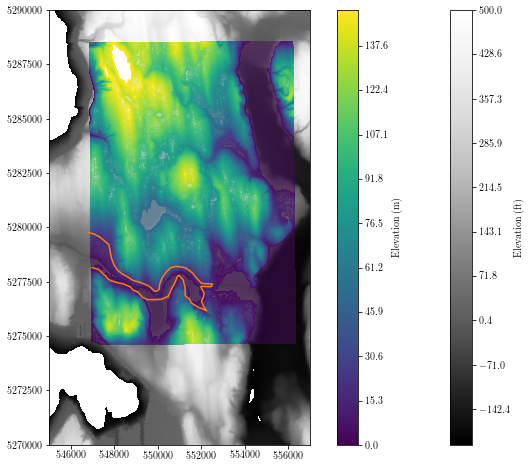

In [4]:
fig, ax = plot_dems()

def plot_line_shapefile(shapefile = '../data/the_cut.shp'):
    driver = ogr.GetDriverByName("ESRI Shapefile")
    dataSource = driver.Open(shapefile, 0)
    layer = dataSource.GetLayer()

    # If the shapefile is in a different projection, we need to do this
    inSpatialRef = layer.GetSpatialRef()
    outSpatialRef = osr.SpatialReference() 
    outSpatialRef.ImportFromEPSG(26910)
    coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)


    for feature in layer:
        geom = feature.GetGeometryRef()
        geom.Transform(coordTransform)
        pts = geom.ExportToWkt()[12:-1].split(',')
        pt_arr = np.array([x.split(' ') for x in pts])
        ax.plot(pt_arr[:, 0], pt_arr[:, 1], color='C1')
        
# retain our limits
xlim, ylim = ax.get_xlim(), ax.get_ylim()
plot_line_shapefile()
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

## Polygon shapefile

Now we get to learn what patches are!

(5269990.0, 5290000.0)

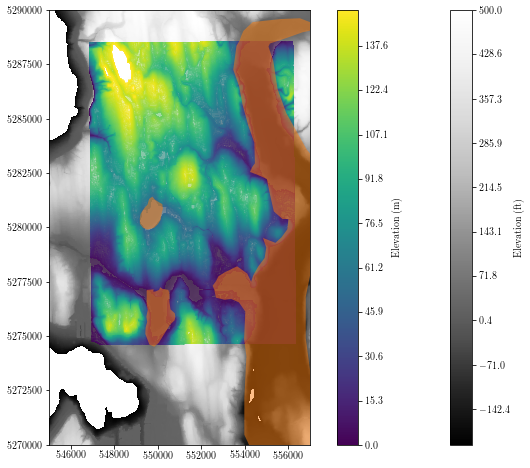

In [6]:
from matplotlib.patches import Polygon

fig, ax = plot_dems()
xlim, ylim = ax.get_xlim(), ax.get_ylim()

def plot_poly_shapefile(shapefile = '../data/lakes.shp'):
    driver = ogr.GetDriverByName("ESRI Shapefile")
    dataSource = driver.Open(shapefile, 0)
    layer = dataSource.GetLayer()

    # If the shapefile is in a different projection, we need to do this
    inSpatialRef = layer.GetSpatialRef()
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.ImportFromEPSG(26910)
    coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

    # Now loop through polygons
    for feature in layer:
        geom = feature.GetGeometryRef()
        geom.Transform(coordTransform)
        pts = geom.ExportToWkt().split('(')[-1].rstrip(') ').split(',')
        pt_arr = np.array([x.split(' ') for x in pts])
        poly = Polygon(pt_arr, facecolor='C1', fill=True, alpha=0.5)
        ax.add_patch(poly)  # Otherwise the patch doesnt show up

plot_poly_shapefile()
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)